# StanDep
StanDep is a heuristic method for using transcriptomics to identify core reactions prior to building context-specific metabolic models. StanDep clusters gene expression data based on their expression pattern across different contexts and determines thresholds for each cluster using data-dependent statistics, specifically standard deviation and mean. 

In [1]:
warning('off', 'all');

In [2]:
% Initialize COBRA
initCobraToolbox



      _____   _____   _____   _____     _____     |
     /  ___| /  _  \ |  _  \ |  _  \   / ___ \    |   COnstraint-Based Reconstruction and Analysis
     | |     | | | | | |_| | | |_| |  | |___| |   |   The COBRA Toolbox - 2024
     | |     | | | | |  _  { |  _  /  |  ___  |   |
     | |___  | |_| | | |_| | | | \ \  | |   | |   |   Documentation:
     \_____| \_____/ |_____/ |_|  \_\ |_|   |_|   |   http://opencobra.github.io/cobratoolbox
                                                  | 

 > Checking if git is installed ...  Done (version: 2.39.3).
 > Checking if the repository is tracked using git ...  Done.
 > Checking if curl is installed ...  Done.
 > Checking if remote can be reached ...  Done.
 > Initializing and updating submodules (this may take a while)... Done.
 > Adding all the files of The COBRA Toolbox ...  Done.
 > Define CB map output... set to svg.
 > Configuring solver environment variables ...
   - [----] ILOG_CPLEX_PATH: --> set this path manually after instal

In [3]:
cd('/Users/pablodigiusto/Documents/GitHub/Whole-Cell-Network-Reconstruction-for-CHO-cells/Notebooks');
addpath('./Matlab code/Standep');

In [4]:
% Load iCHO3644 model
model = readCbModel('iCHO3644_unblocked.mat');
model

Each model.subSystems{x} is a character array, and this format is retained.

model = 

  struct with fields:

              S: [4689x8549 double]
           mets: {4689x1 cell}
              b: [4689x1 double]
         csense: [4689x1 char]
           rxns: {8549x1 cell}
             lb: [8549x1 double]
             ub: [8549x1 double]
              c: [8549x1 double]
      osenseStr: 'max'
          genes: {2948x1 cell}
          rules: {8549x1 cell}
      geneNames: {2948x1 cell}
      compNames: {9x1 cell}
          comps: {9x1 cell}
    metFormulas: {4689x1 cell}
       metNames: {4689x1 cell}
        grRules: {8549x1 cell}
     rxnGeneMat: [8549x2948 double]
       rxnNames: {8549x1 cell}
     subSystems: {8549x1 cell}
    description: 'iCHO3644_unblocked.mat'
        modelID: 'iCHO3644'
       metComps: [4689x1 int64]



In [5]:
% Create a dictionary with the gene names of our model as keys and the gene IDs as values

genes = model.genes; % or model.rxns or another field depending on your model
geneNames = model.geneNames; % Adjust field name as per your model's structure

% Initialize a map (dictionary) to hold gene names as keys and genes IDs as values
geneDict = containers.Map('KeyType', 'char', 'ValueType', 'char');

% Iterate over the genes
for i = 1:length(genes)
    geneID = genes{i};
    geneName = geneNames{i};
    geneDict(geneName) = geneID; % Use gene name as key, gene ID as value
end

In [6]:
% Loading the RNA-seq data
dataTable = readtable('../Data/Zela Data/20200307_Bio141-148_merged.tpm.tsv', 'FileType', 'text', 'Delimiter', '\t');

% Extracting gene names if the first column
geneNames = dataTable{:, 1};

% Map gene IDs from the model to the RNA-Seq data
for i = 1:length(geneNames)
    currentGeneName = geneNames{i};
    if isKey(geneDict, currentGeneName)
        % If the current gene name exists in the dictionary, replace it with the gene ID
        updatedGeneNames{i} = geneDict(currentGeneName);
    else
        % If the gene name does not exist in the dictionary, keep the original name
        updatedGeneNames{i} = currentGeneName;
    end
end

% Sample Identifiers and Their Conditions
sampleConditions = {
    'S1', 'WT_P2'; 'S7', 'WT_P2'; 'S13', 'WT_P2';
    'S2', 'WT_P4'; 'S8', 'WT_P4'; 'S14', 'WT_P4';
    'S3', 'WT_P6'; 'S9', 'WT_P6'; 'S15', 'WT_P6';
    'S4', 'WT_P8'; 'S10', 'WT_P8'; 'S16', 'WT_P8';
    'S5', 'WT_P12';'S11', 'WT_P12';
    'S6', 'WT_P14';'S12', 'WT_P14';'S17', 'WT_P14';
    'S18', 'ZeLa_P4'; 'S23', 'ZeLa_P4'; 'S28', 'ZeLa_P4'; 'S34', 'ZeLa_P4'; 'S39', 'ZeLa_P4';
    'S19', 'ZeLa_P6'; 'S24', 'ZeLa_P6'; 'S29', 'ZeLa_P6'; 'S35', 'ZeLa_P6'; 'S40', 'ZeLa_P6';
    'S20', 'ZeLa_P8'; 'S25', 'ZeLa_P8'; 'S30', 'ZeLa_P8'; 'S36', 'ZeLa_P8'; 'S41', 'ZeLa_P8';
    'S21', 'ZeLa_P12';'S26', 'ZeLa_P12';'S31', 'ZeLa_P12';'S37', 'ZeLa_P12';'S42', 'ZeLa_P12';
    'S22', 'ZeLa_P14';'S27', 'ZeLa_P14';'S32', 'ZeLa_P14';'S38', 'ZeLa_P14';'S43', 'ZeLa_P14';
    'S18', 'ZeLa_P2'; 'S22', 'ZeLa_P2'; 'S27', 'ZeLa_P2'; 'S33', 'ZeLa_P2'; 'S38', 'ZeLa_P2';
};

% Prepare the expression data matrix and cell names
expressionDataMatrix = table2array(dataTable(:, 2:end)); % Assuming the first column is gene names
cellNames = dataTable.Properties.VariableNames(2:end); % Adjust if the structure is different

% Adjust cellNames based on sampleConditions
for i = 1:size(sampleConditions, 1)
    idx = find(strcmp(cellNames, sampleConditions{i, 1}));
    if ~isempty(idx)
        cellNames{idx} = sampleConditions{i, 2};
    end
end

% Creating the expressionData Structure
expressionData = struct;
expressionData.gene = updatedGeneNames;
expressionData.valuebyTissue = expressionDataMatrix;
expressionData.Tissue = cellNames;

In [7]:
expressionData


expressionData = 

  struct with fields:

             gene: {1x32426 cell}
    valuebyTissue: [32426x43 double]
           Tissue: {1x43 cell}



In [8]:
% Get the mean values of gene expression per condition

% Find unique condition names
uniqueConditions = unique(cellNames);

% Initialize a matrix to store the mean values for each condition
meanExpressionDataMatrix = zeros(size(expressionDataMatrix, 1), length(uniqueConditions));

% Loop over each unique condition to calculate the mean expression
for i = 1:length(uniqueConditions)
    % Find columns that belong to the current condition
    conditionCols = strcmp(cellNames, uniqueConditions{i});
    
    % Calculate the mean across these columns for each gene
    meanExpressionDataMatrix(:, i) = mean(expressionDataMatrix(:, conditionCols), 2);
end

% Creating the meanexpressionData Structure
meanexpressionData = struct;
meanexpressionData.gene = updatedGeneNames;
meanexpressionData.valuebyTissue = meanExpressionDataMatrix;
meanexpressionData.Tissue = uniqueConditions;

In [9]:
meanexpressionData


meanexpressionData = 

  struct with fields:

             gene: {1x32426 cell}
    valuebyTissue: [32426x12 double]
           Tissue: {1x12 cell}



In [10]:
% extract expression data of the genes in the model
modelData = getModelData(meanexpressionData,model);

In [11]:
modelData


modelData = 

  struct with fields:

              gene: {1x2789 cell}
            Tissue: {1x12 cell}
             value: [2789x12 double]
    ID_geneMissing: {159x1 cell}
    ID_genePresent: {2789x1 cell}



In [12]:
% Calculate enzymes in the model
spec = getSpecialistEnzymes(model);  
prom = getPromEnzymes(model);

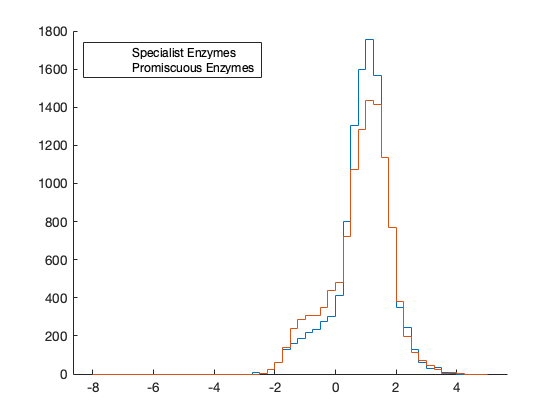

In [13]:
% Calculate enzyme expression
enzymeData = comparePromiscuousSpecific(spec,prom,modelData);

In [14]:
edgeX = [-2 -1 0 1 2 2.5 3 4]; % bins  
k = 7 % what value should we use
distMethod = 'euclidean'; % distance method  
linkageMethod = 'complete'; % linkage metric for hierarchical clustering


k =

     7



Cophenetic correlation coeffcient using complete linkage and euclidean distance = 0.8222


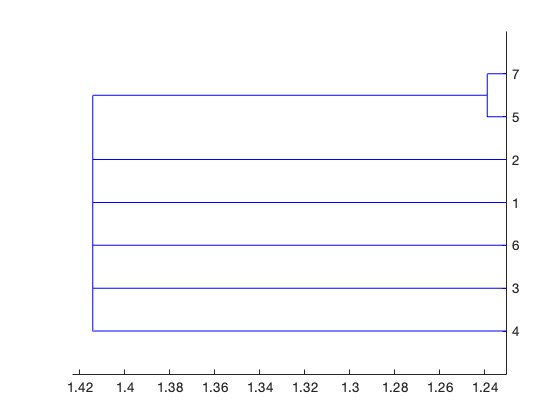

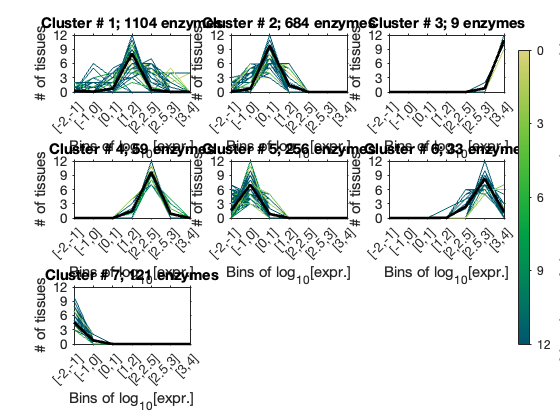

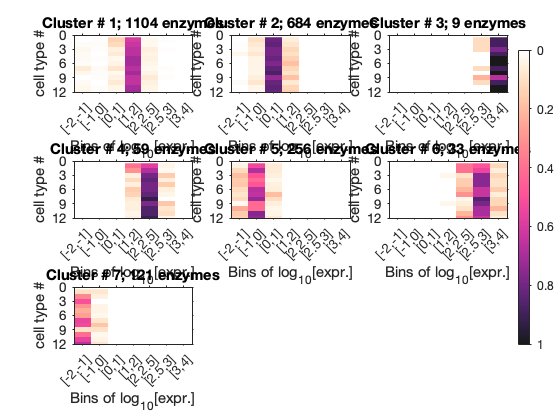

In [15]:
% Calculate clusters of enzyme expression
clustObj = geneExprDist_hierarchy(enzymeData,[],edgeX,k,distMethod,linkageMethod);

Top 25th percentile for the data = 1.4752
Mean of Data = 0.8692
Std. Dev. of Data = 0.2539
fraction selected = 0.4080
fraction selected = 0.4198
fraction selected = 1.0000
fraction selected = 0.8503
fraction selected = 0.0365
fraction selected = 0.8662
fraction selected = 0.0007
Cophenetic correlation coeffcient using complete linkage and euclidean distance = 0.8352


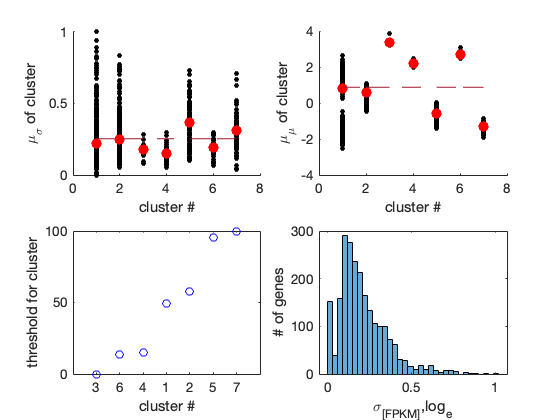

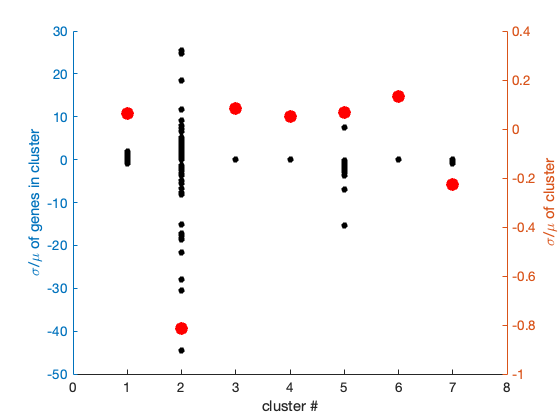

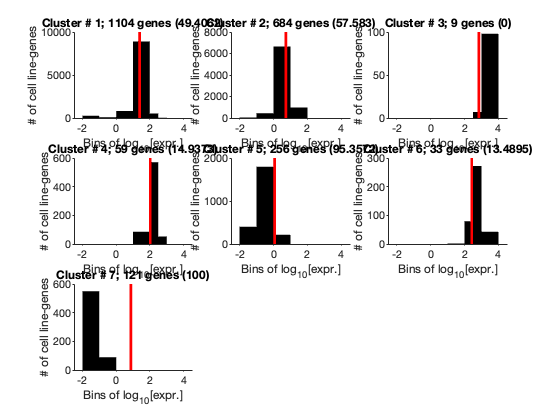

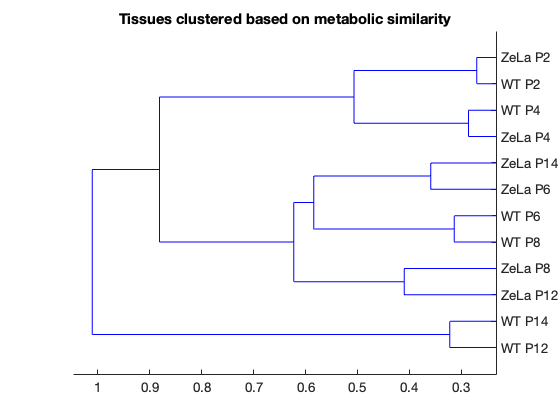

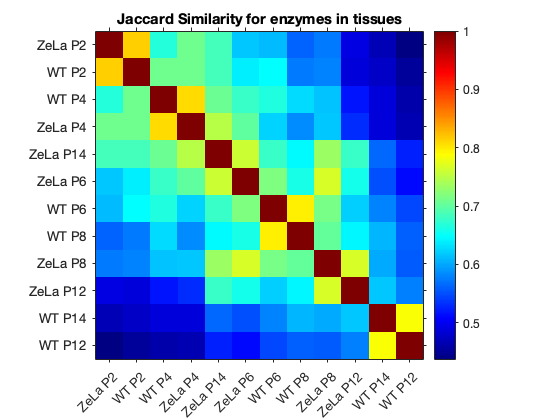

In [16]:
% calculate active reaction lists as binary matrix
coreRxnMat = models4mClusters1(clustObj,enzymeData.Tissue,model,edgeX,[],[],true,0,[1 1]);

Cophenetic correlation coeffcient using complete linkage and euclidean distance = 0.8750


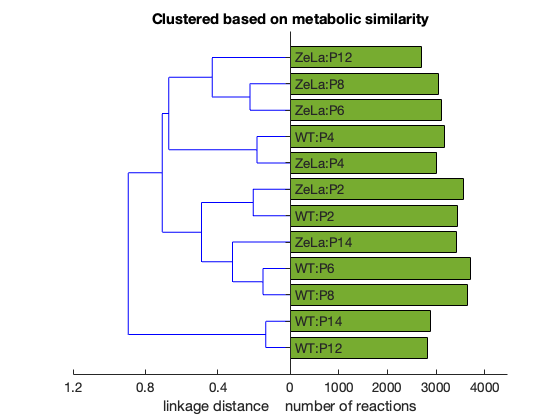

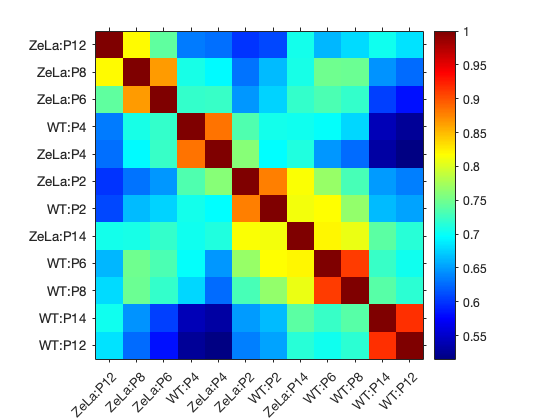

In [17]:
% calculate Jaccard similarity between core reaction lists
calcJaccardSimilarity(coreRxnMat,enzymeData.Tissue,'matrix',true);

In [18]:
% Calculate ubiquity scores for mCADRE
ubiScores = getUbiquityScore(clustObj,edgeX,model); % calculate ubiquity score

Top 25th percentile for the data = 1.4752
Mean of Data = 0.8692
Std. Dev. of Data = 0.2539


In [20]:
% Save the outputs to a .mat file
save('../Data/Context_specific_models/UbiquityScores.mat', 'ubiScores');